## Exploratory Data Analysis

### Author: Rajiv Swamy
### Course: SML 312

## AirBnB Data Analysis: Austin, TX

In [56]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Data Assumptions:
http://insideairbnb.com/data-assumptions
- Location data is anaonymized and varies from actual location by up to 150 meters

## New Modeling

In [57]:
# General imports for pre-processing data and modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# Model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score 

# Model evaluation
from sklearn import metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate


# Ensemble methods
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance

In [58]:
df = pd.read_csv('./airbnb_data/austin/03-2022/listings_cleaned_future.csv')

In [59]:
df.shape

(8834, 65)

In [60]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'has_availability', 'availability_30', 'availability_90',
       'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings

In [92]:
df['nights_booked_est'].mean()

15.909634852356158

In [61]:
df['nights_booked_flag'] = (df['nights_booked_est'] <= df['nights_booked_est'].mean()).replace({True: 0, False: 1})
df.loc[df['nights_booked_est'] > 180, 'nights_booked_est'] = 180
df.loc[df['price'] > 1000, 'price'] = 1000

In [62]:
(df['nights_booked_est']==0).sum()

3631

<AxesSubplot: >

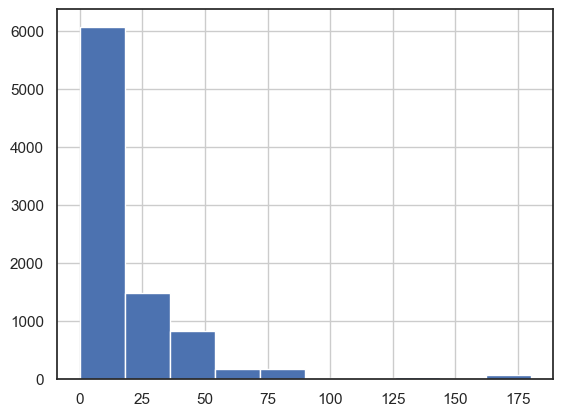

In [63]:
df['nights_booked_est'].hist()

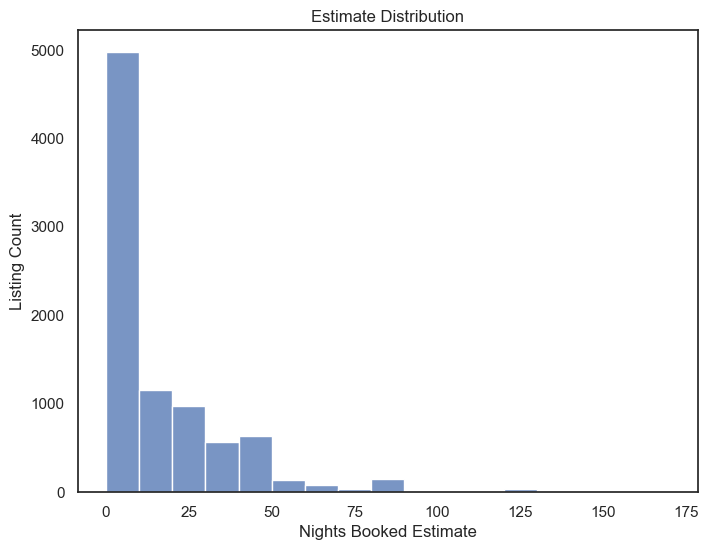

In [64]:
plt.figure(figsize=(8,6))
bins = np.arange(0,180,10)
ax = sns.histplot(x='nights_booked_est', data=df, bins = bins)
ax.set(xlabel='Nights Booked Estimate', ylabel='Listing Count', title="Estimate Distribution")
plt.show()

In [65]:
df.drop(['id','host_id','host_since','host_response_rate','host_acceptance_rate','first_review','last_review','amenities','property_type','calendar_last_scraped'], axis = 1, inplace=True)

df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].astype(str)

In [66]:
transformed_df = pd.get_dummies(df, drop_first=True)

In [67]:
numerical_columns = ['latitude','longitude','accommodates','bathrooms',
                    'bedrooms','beds','price','minimum_nights','maximum_nights',
                    'maximum_nights_avg_ntm', 'minimum_nights_avg_ntm',
                    'availability_30','availability_90','number_of_reviews',
                    'number_of_reviews_ltm','number_of_reviews_l30d',
                    'calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                    'host_days_active', 'description_sentiment', 'number_of_reviews_future','delta_num_reviews','nights_booked_est']


Areas of multi-collinearity:

- `beds`, `bedrooms`,`bathrooms` and the number of people that a property `accommodates` are highly correlated. 
- there is perf correlation between `nan` unknown review labels for different review categories
- Same result for `host_response_rate_bins_unknown` and `host_response_time_bins_unknown`. One of these rates will be dropped.


In [71]:
to_drop_coll = ['beds',
           'bedrooms',
           'host_response_rate_bins_unknown',
           'host_response_time_unknown',
           'review_scores_accuracy_no reviews',
           'review_scores_cleanliness_no reviews',
           'review_scores_communication_no reviews',
           'review_scores_location_no reviews',
           'review_scores_value_no reviews',
           'availability_30',
           'availability_90']

transformed_df.drop(to_drop_coll, axis=1, inplace=True)

### Standardize and Normalize

array([[<AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'accommodates'}>,
        <AxesSubplot: title={'center': 'bathrooms'}>,
        <AxesSubplot: title={'center': 'price'}>],
       [<AxesSubplot: title={'center': 'minimum_nights'}>,
        <AxesSubplot: title={'center': 'maximum_nights'}>,
        <AxesSubplot: title={'center': 'maximum_nights_avg_ntm'}>,
        <AxesSubplot: title={'center': 'minimum_nights_avg_ntm'}>,
        <AxesSubplot: title={'center': 'number_of_reviews'}>],
       [<AxesSubplot: title={'center': 'number_of_reviews_ltm'}>,
        <AxesSubplot: title={'center': 'number_of_reviews_l30d'}>,
        <AxesSubplot: title={'center': 'calculated_host_listings_count'}>,
        <AxesSubplot: title={'center': 'calculated_host_listings_count_entire_homes'}>,
        <AxesSubplot: title={'center': 'calculated_host_listings_count_private_rooms'}>],
       [<AxesSubplot: title={'

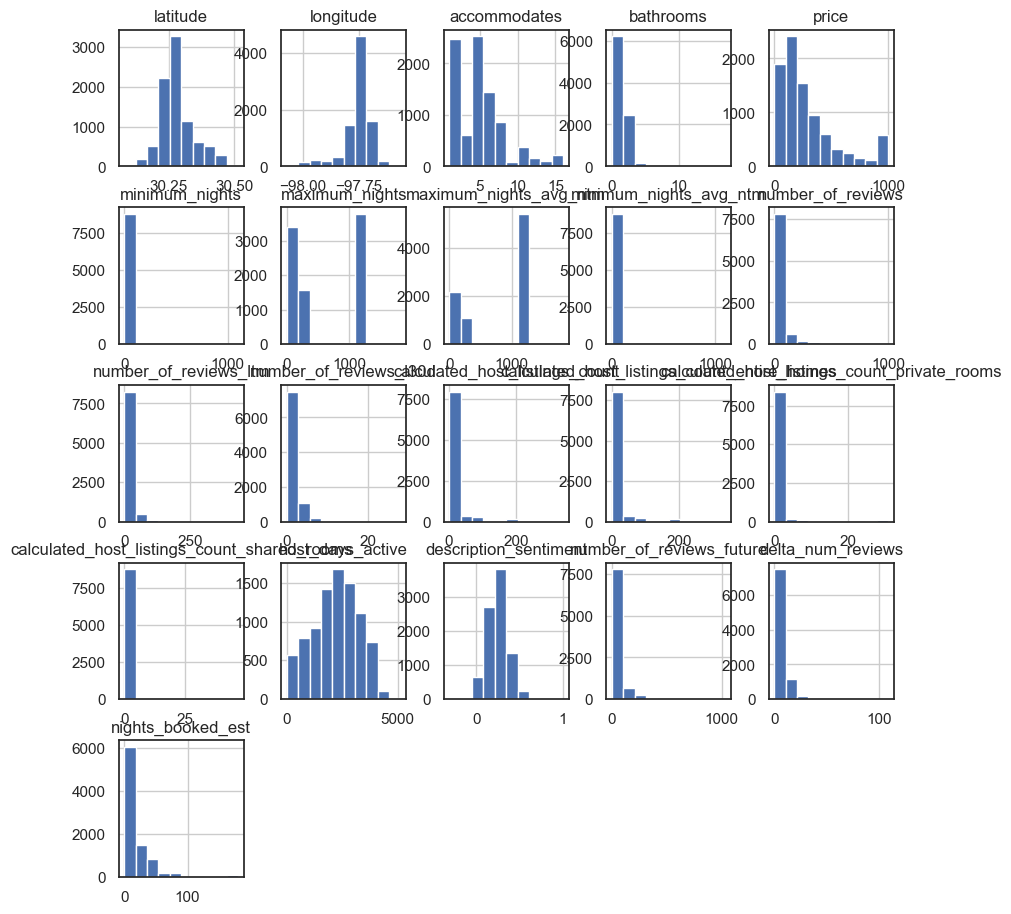

In [72]:
numerical_columns = ['latitude','longitude','accommodates','bathrooms',
                    'price','minimum_nights','maximum_nights',
                    'maximum_nights_avg_ntm', 'minimum_nights_avg_ntm',
                    'number_of_reviews',
                    'number_of_reviews_ltm','number_of_reviews_l30d',
                    'calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                    'host_days_active', 'description_sentiment', 'number_of_reviews_future','delta_num_reviews','nights_booked_est']

# View numerical columns
transformed_df[numerical_columns].hist(figsize=(10,11))

In [53]:
for col in numerical_columns:
    print(transformed_df[col].min())

30.07887
-98.07094
1
0.0
1.0
1
1
1.0
1.0
0
0
0
1
0
0
0
3.0
-0.3124999999999999
0
0
0.0


In [73]:
np.log(0.1)

-2.3025850929940455

Other than `availability_30`, `availability_90` and `host_days_active`, latitude/longitude, the remaining numerical features are  postively skewed. A log transformation would be beneficial to modify the scale of the data.

In [74]:
# Log transforming columns
log_numerical_columns = [i for i in numerical_columns 
                     if i not in ['latitude','longitude', 'host_days_active', 'description_sentiment']] # Removing items not to be transformed

for col in log_numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.1)
    transformed_df[col] = np.log(transformed_df[col])

array([[<AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'accommodates'}>,
        <AxesSubplot: title={'center': 'bathrooms'}>,
        <AxesSubplot: title={'center': 'price'}>],
       [<AxesSubplot: title={'center': 'minimum_nights'}>,
        <AxesSubplot: title={'center': 'maximum_nights'}>,
        <AxesSubplot: title={'center': 'maximum_nights_avg_ntm'}>,
        <AxesSubplot: title={'center': 'minimum_nights_avg_ntm'}>,
        <AxesSubplot: title={'center': 'number_of_reviews'}>],
       [<AxesSubplot: title={'center': 'number_of_reviews_ltm'}>,
        <AxesSubplot: title={'center': 'number_of_reviews_l30d'}>,
        <AxesSubplot: title={'center': 'calculated_host_listings_count'}>,
        <AxesSubplot: title={'center': 'calculated_host_listings_count_entire_homes'}>,
        <AxesSubplot: title={'center': 'calculated_host_listings_count_private_rooms'}>],
       [<AxesSubplot: title={'

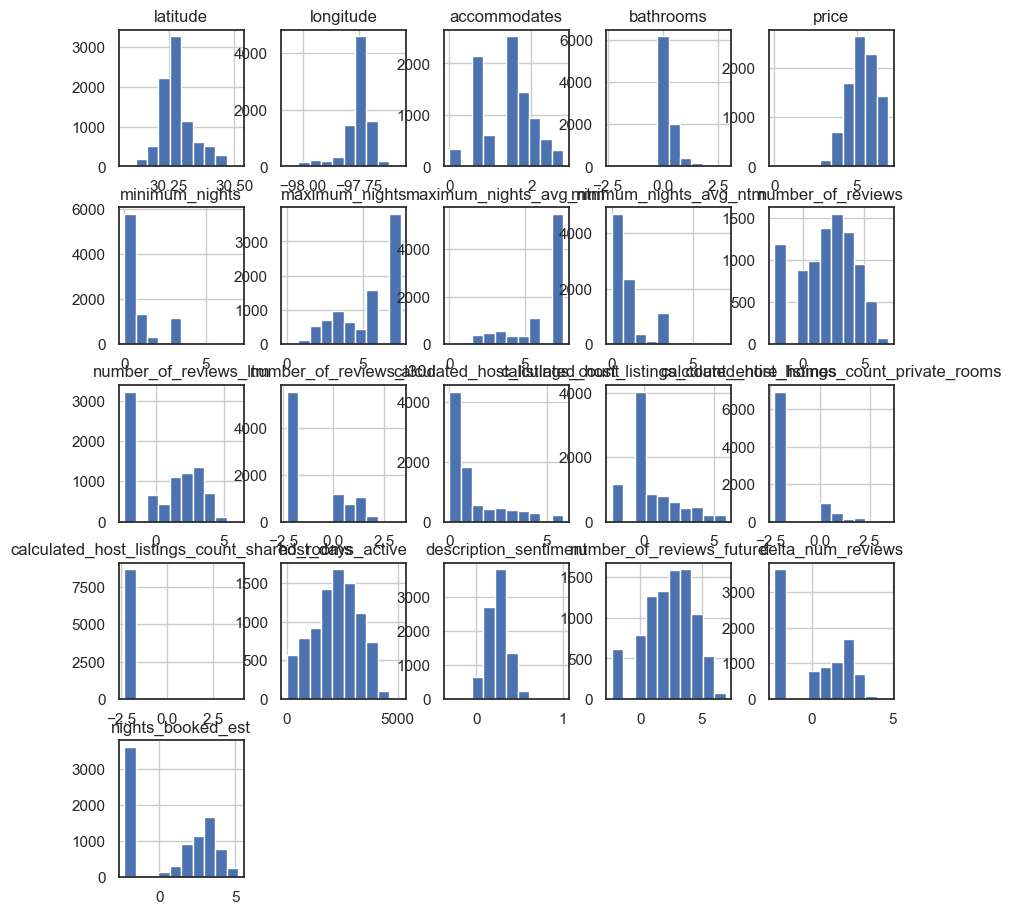

In [75]:
transformed_df[numerical_columns].hist(figsize=(10,11))

### Separate X, y and apply std scaler

In [76]:
to_drop = ['minimum_nights','minimum_nights_avg_ntm','number_of_reviews_future','delta_num_reviews']

# numerical_columns = [x for x in numerical_columns if not (x in to_drop or x in to_drop_coll)]

transformed_df.drop(to_drop, axis=1, inplace=True)

### Regression Case

In [77]:
# Separating X and y
X = transformed_df.drop(['nights_booked_est','nights_booked_flag'], axis=1)
y = transformed_df.nights_booked_est
X_unscaled = X.copy()

# Cols of interest
cols = ['latitude','longitude','accommodates','bathrooms',
                    'maximum_nights', 'maximum_nights_avg_ntm','number_of_reviews',
                    'number_of_reviews_ltm','number_of_reviews_l30d',
                    'calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                    'host_days_active','description_sentiment']

# Scaling, get zero mean, unit variance for all input features
num_features = X[cols].copy()
scaler = StandardScaler().fit(num_features.values)
num_features = scaler.transform(num_features.values)

X[cols] = num_features
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [78]:
# Splitting into train, validation, and test sets
# Distribution is 80/20, then 80/20 of the 80 percent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=57) 

In [80]:
X_train.shape

(5653, 115)

Print the size of the train, val, and test sets

In [79]:
print(f"Train Set Size; {X_train.shape[0]}")
print(f"Validation Set Size; {X_val.shape[0]}")
print(f"Test Set Size; {X_test.shape[0]}")

Train Set Size; 5653
Validation Set Size; 1414
Test Set Size; 1767


Helper function for executing diff models/algorithms

In [84]:
model_meta_data = []

# Function to execute model and addd metadata
def execute_model(model, model_metadata, X_train, X_test, Y_train, Y_test, id, fit=True):
    if fit:
        model.fit(X_train,Y_train)

    Y_train_pred  = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # Acquire train/test MSE scores after inverse transform
    mse_train = mean_squared_error(Y_train,Y_train_pred)
    mse_test = mean_squared_error(Y_test,Y_test_pred)

    # Precision score for train/test data
    rsq_train = r2_score(Y_train,Y_train_pred)
    rsq_test = r2_score(Y_test,Y_test_pred)


    # Acquire train/test MSE scores after inverse transform
    mse_train_inv = mean_squared_error(np.exp(Y_train),np.exp(Y_train_pred))
    mse_test_inv = mean_squared_error(np.exp(Y_test),np.exp(Y_test_pred))

    # Precision score for train/test data
    rsq_train_inv = r2_score(np.exp(Y_train),np.exp(Y_train_pred))
    rsq_test_inv = r2_score(np.exp(Y_test),np.exp(Y_test_pred))

    # Apply 3-fold cross validation to understand model
    scores = cross_validate(model, X_train, Y_train, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)


    print(scores)

    # Store results in model metadata obj
    meta_data = {"model": model, 
                "id": id,
                "r2_train": rsq_train,
                "r2_test": rsq_test,
                "r2_train_inv": rsq_train_inv,
                "r2_test_inv": rsq_test_inv,
                "train_cross_val_r2": scores['train_r2'].mean(),
                "test_cross_val_r2": scores['test_r2'].mean(),
                "mse_train": mse_train,
                "mse_test": mse_test,
                "mse_train_inv": mse_train_inv,
                "mse_test_inv": mse_test_inv,
                "train_cross_val_mse": abs(scores['train_neg_mean_squared_error'].mean()),
                "test_cross_val_mse": abs(scores['test_neg_mean_squared_error'].mean()),
                }
    
    # print values
    for key, val in meta_data.items():
        print(key, val)
    

    model_metadata.append(meta_data)

    return Y_train_pred, Y_test_pred

In [85]:
def plot_pred_actual(actual, pred, model_name):
    fig, ax = plt.subplots(figsize=(5, 4))


    ax.scatter(actual, pred, alpha=.7) #alpha helps to show overlapping data
    ax.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=4, label = 'y=x')

    ax.set_xlabel('Actual Log Nights Booked Est.')  
    ax.legend()
    ax.set_ylabel('Predicted Log Nights Booked Est.')  
    ax.set_title(model_name)  
    plt.show()

def plot_pred_actual_inv(actual, pred, model_name):
    fig, ax = plt.subplots(figsize=(5, 4))


    ax.scatter(np.exp(actual), np.exp(pred), alpha=.7, color='b') #alpha helps to show overlapping data
    ax.plot([np.exp(actual).min(), np.exp(actual).max()], [np.exp(actual).min(), np.exp(actual).max()], 'k--', lw=4, label = 'y=x')

    ax.set_xlabel('Actual Nights Booked Est.')  
    ax.legend()
    ax.set_ylabel('Predicted Nights Booked Est.')  
    ax.set_title(model_name)  
    plt.show()

{'fit_time': array([0.33346891, 0.08002567, 0.09936094, 0.51292491, 0.09383702]), 'score_time': array([0.00806594, 0.00886822, 0.00733399, 0.00830173, 0.00624108]), 'test_r2': array([0.60603405, 0.60905511, 0.57529251, 0.6136715 , 0.64208988]), 'train_r2': array([0.62863054, 0.62761256, 0.63685593, 0.62692322, 0.61962766]), 'test_neg_mean_squared_error': array([-2.76131944, -2.7016896 , -3.09298346, -2.71982528, -2.55661465]), 'train_neg_mean_squared_error': array([-2.63477807, -2.651064  , -2.5515898 , -2.64399377, -2.68577476])}
model LinearRegression()
id lin-reg
r2_train 0.6260843277207653
r2_test 0.5758464060842142
r2_train_inv 0.06750082283880665
r2_test_inv 0.03768654188422538
train_cross_val_r2 0.6279299801054562
test_cross_val_r2 0.6092286114983707
mse_train 2.646449416829255
mse_test 2.935282743390087
mse_train_inv 581.778947037535
mse_test_inv 548.0388047029877
train_cross_val_mse 2.633440079600402
test_cross_val_mse 2.766486486183601


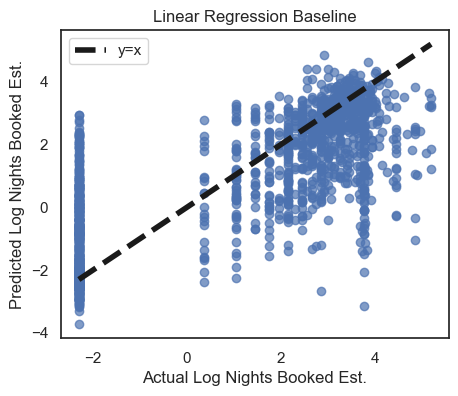

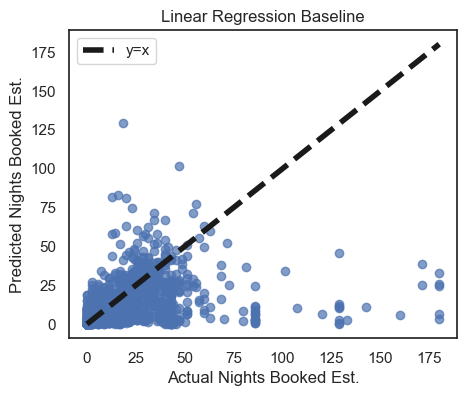

In [86]:
# Fit and analyze linear regression model
lin_reg = LinearRegression()  

# Run model with helper function
y_train_pred, y_val_pred = execute_model(lin_reg, model_meta_data, X_train, X_val, y_train, y_val, 'lin-reg')

plot_pred_actual(y_val, y_val_pred,'Linear Regression Baseline')
plot_pred_actual_inv(y_val, y_val_pred, 'Linear Regression Baseline')

### Ridge Regressionn
Application of L2 regularizer

{'fit_time': array([0.07250929, 0.06964517, 0.07000589, 0.05834794, 0.0279932 ]), 'score_time': array([0.01917577, 0.01611972, 0.01665497, 0.01400995, 0.0067997 ]), 'test_r2': array([0.60542508, 0.60879603, 0.57538093, 0.61471179, 0.64307175]), 'train_r2': array([0.62850156, 0.62747171, 0.63669927, 0.62671824, 0.61943147]), 'test_neg_mean_squared_error': array([-2.76558771, -2.70347999, -3.09233956, -2.71250149, -2.54960102]), 'train_neg_mean_squared_error': array([-2.63569317, -2.65206669, -2.55269051, -2.64544646, -2.68716004])}
model Ridge()
id ridge
r2_train 0.6259652054222256
r2_test 0.5761757114685888
r2_train_inv 0.0686578772480887
r2_test_inv 0.03829197642159721
train_cross_val_r2 0.6277644498105189
test_cross_val_r2 0.609477115516948
mse_train 2.6472925244090475
mse_test 2.9330038415348976
mse_train_inv 581.057069836585
mse_test_inv 547.694008922165
train_cross_val_mse 2.6346113742855
test_cross_val_mse 2.764701954300796


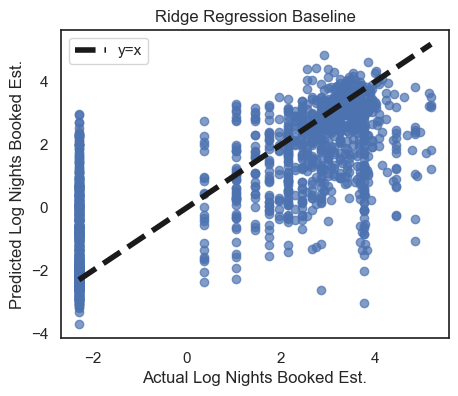

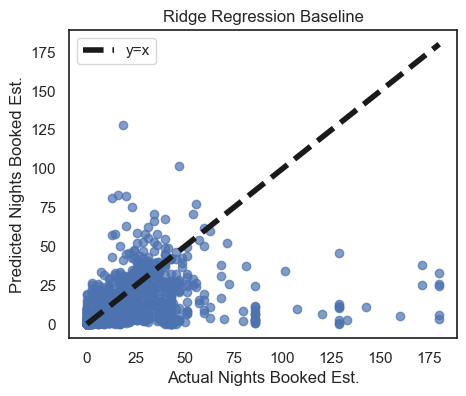

In [87]:
# Fit and analyze linear regression model
lin_reg = linear_model.Ridge()  

# Run model with helper function
y_train_pred, y_val_pred = execute_model(lin_reg, model_meta_data, X_train, X_val, y_train, y_val, 'ridge')

plot_pred_actual(y_val, y_val_pred,'Ridge Regression Baseline')
plot_pred_actual_inv(y_val, y_val_pred, 'Ridge Regression Baseline')

{'fit_time': array([0.02608895, 0.02880812, 0.02019882, 0.01225686, 0.01510882]), 'score_time': array([0.00598979, 0.00437593, 0.00529218, 0.00378609, 0.00256014]), 'test_r2': array([0.31826861, 0.32955043, 0.31469047, 0.31812947, 0.34262642]), 'train_r2': array([0.32948612, 0.32831958, 0.32840548, 0.33003473, 0.31128747]), 'test_neg_mean_squared_error': array([-4.77827626, -4.63325309, -4.9908492 , -4.80049679, -4.69573459]), 'train_neg_mean_squared_error': array([-4.75713663, -4.78176109, -4.71888119, -4.74804139, -4.86293698])}
model Lasso(alpha=1)
id lasso
r2_train 0.3254406651938534
r2_test 0.309249030383805
r2_train_inv -0.20793525049458994
r2_test_inv -0.22651514371816628
train_cross_val_r2 0.3255066753865755
test_cross_val_r2 0.3246530814512822
mse_train 4.7743041828995745
mse_test 4.829290405686708
mse_train_inv 753.6213600334199
mse_test_inv 783.6676969429901
train_cross_val_mse 4.773751456397721
test_cross_val_mse 4.779721986813543


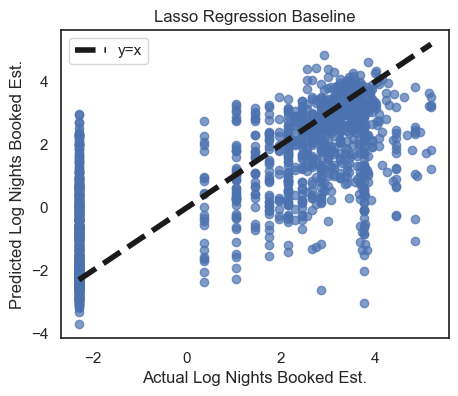

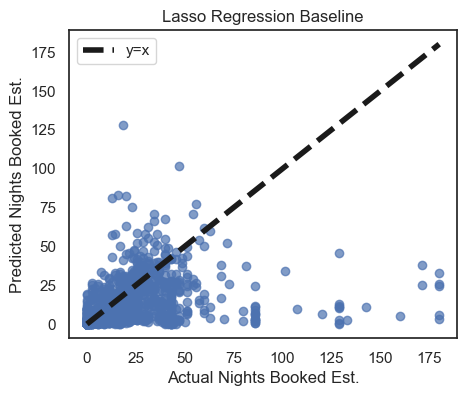

In [88]:
# Fit and analyze linear regression model
lin_reg = linear_model.Lasso(alpha=1)  

# Run model with helper function
y_train_pred, y_test_pred = execute_model(lin_reg, model_meta_data, X_train, X_test, y_train, y_test, 'lasso')

plot_pred_actual(y_val, y_val_pred,'Lasso Regression Baseline')
plot_pred_actual_inv(y_val, y_val_pred, 'Lasso Regression Baseline')

### Non-linear Models

#### Random Forest Regression

{'fit_time': array([4.401829  , 4.62755513, 4.09961414, 4.62414789, 4.79635096]), 'score_time': array([0.02935505, 0.0293839 , 0.030581  , 0.02966404, 0.03601885]), 'test_r2': array([0.62334359, 0.62369201, 0.5823815 , 0.62656656, 0.67006806]), 'train_r2': array([0.72725011, 0.72102819, 0.72298079, 0.73245073, 0.71308939]), 'test_neg_mean_squared_error': array([-2.63999635, -2.60053883, -3.04135706, -2.62904162, -2.35676161]), 'train_neg_mean_squared_error': array([-1.93509565, -1.98602864, -1.9464434 , -1.89612069, -2.02584991])}
model RandomForestRegressor(max_depth=7, n_estimators=180)
id random-forest
r2_train 0.7117305501354247
r2_test 0.600834230976572
r2_train_inv 0.15756402757802646
r2_test_inv 0.08756867274303226
train_cross_val_r2 0.7233598425782033
test_cross_val_r2 0.625210346292542
mse_train 2.040274249093469
mse_test 2.7623587548786195
mse_train_inv 525.5892176486888
mse_test_inv 519.6308642950612
train_cross_val_mse 1.9579076554005994
test_cross_val_mse 2.653539093317795

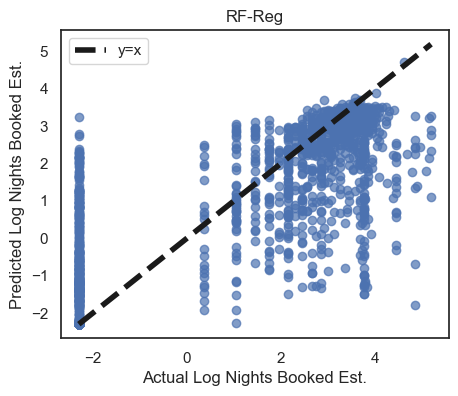

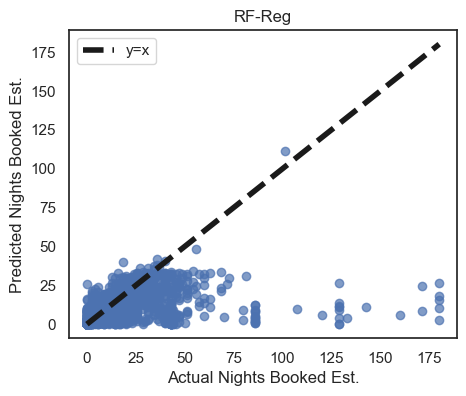

In [91]:
# Create base random forest regressor
rf_reg  = RandomForestRegressor(max_depth = 7, n_estimators=180)

y_train_pred, y_val_pred = execute_model(rf_reg, model_meta_data, X_train, X_val, y_train, y_val, 'random-forest')

plot_pred_actual(y_val, y_val_pred,'RF-Reg')
plot_pred_actual_inv(y_val, y_val_pred, 'RF-Reg')

#### Xgboost

{'fit_time': array([1.08934832, 0.98902678, 1.22331905, 1.37437487, 1.15250301]), 'score_time': array([0.01104474, 0.01797605, 0.01226807, 0.0138011 , 0.01138711]), 'test_r2': array([0.61153876, 0.61557016, 0.56810278, 0.60579135, 0.66749462]), 'train_r2': array([0.95562652, 0.95807503, 0.95255242, 0.95676347, 0.95116469]), 'test_neg_mean_squared_error': array([-2.72273677, -2.65666624, -3.14534354, -2.77530303, -2.37514416]), 'train_neg_mean_squared_error': array([-0.31481931, -0.29846811, -0.33338493, -0.30641713, -0.34482169])}
model XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_ca

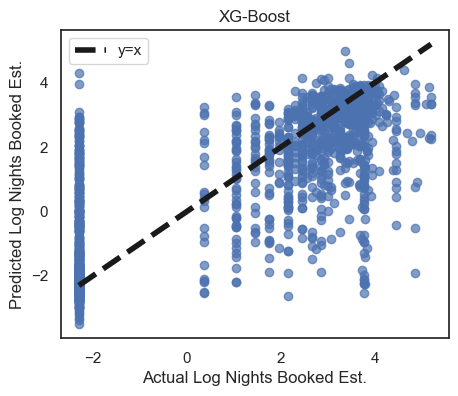

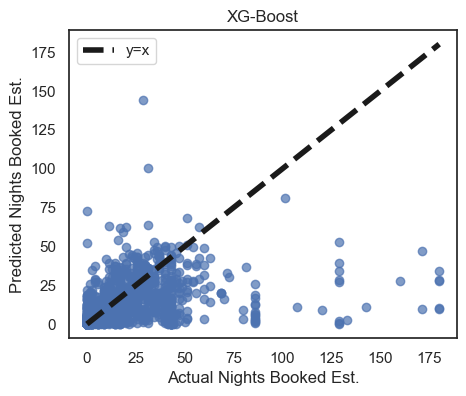

In [90]:
# xgboost regressor with default parameters only
xgb_reg = xgb.XGBRegressor()

y_train_pred, y_val_pred = execute_model(xgb_reg, model_meta_data, X_train, X_val, y_train, y_val, 'xg-boost')

plot_pred_actual(y_val, y_val_pred,'XG-Boost')
plot_pred_actual_inv(y_val, y_val_pred, 'XG-Boost')

#### Plot of Feature importance for baseline xgboost regressor

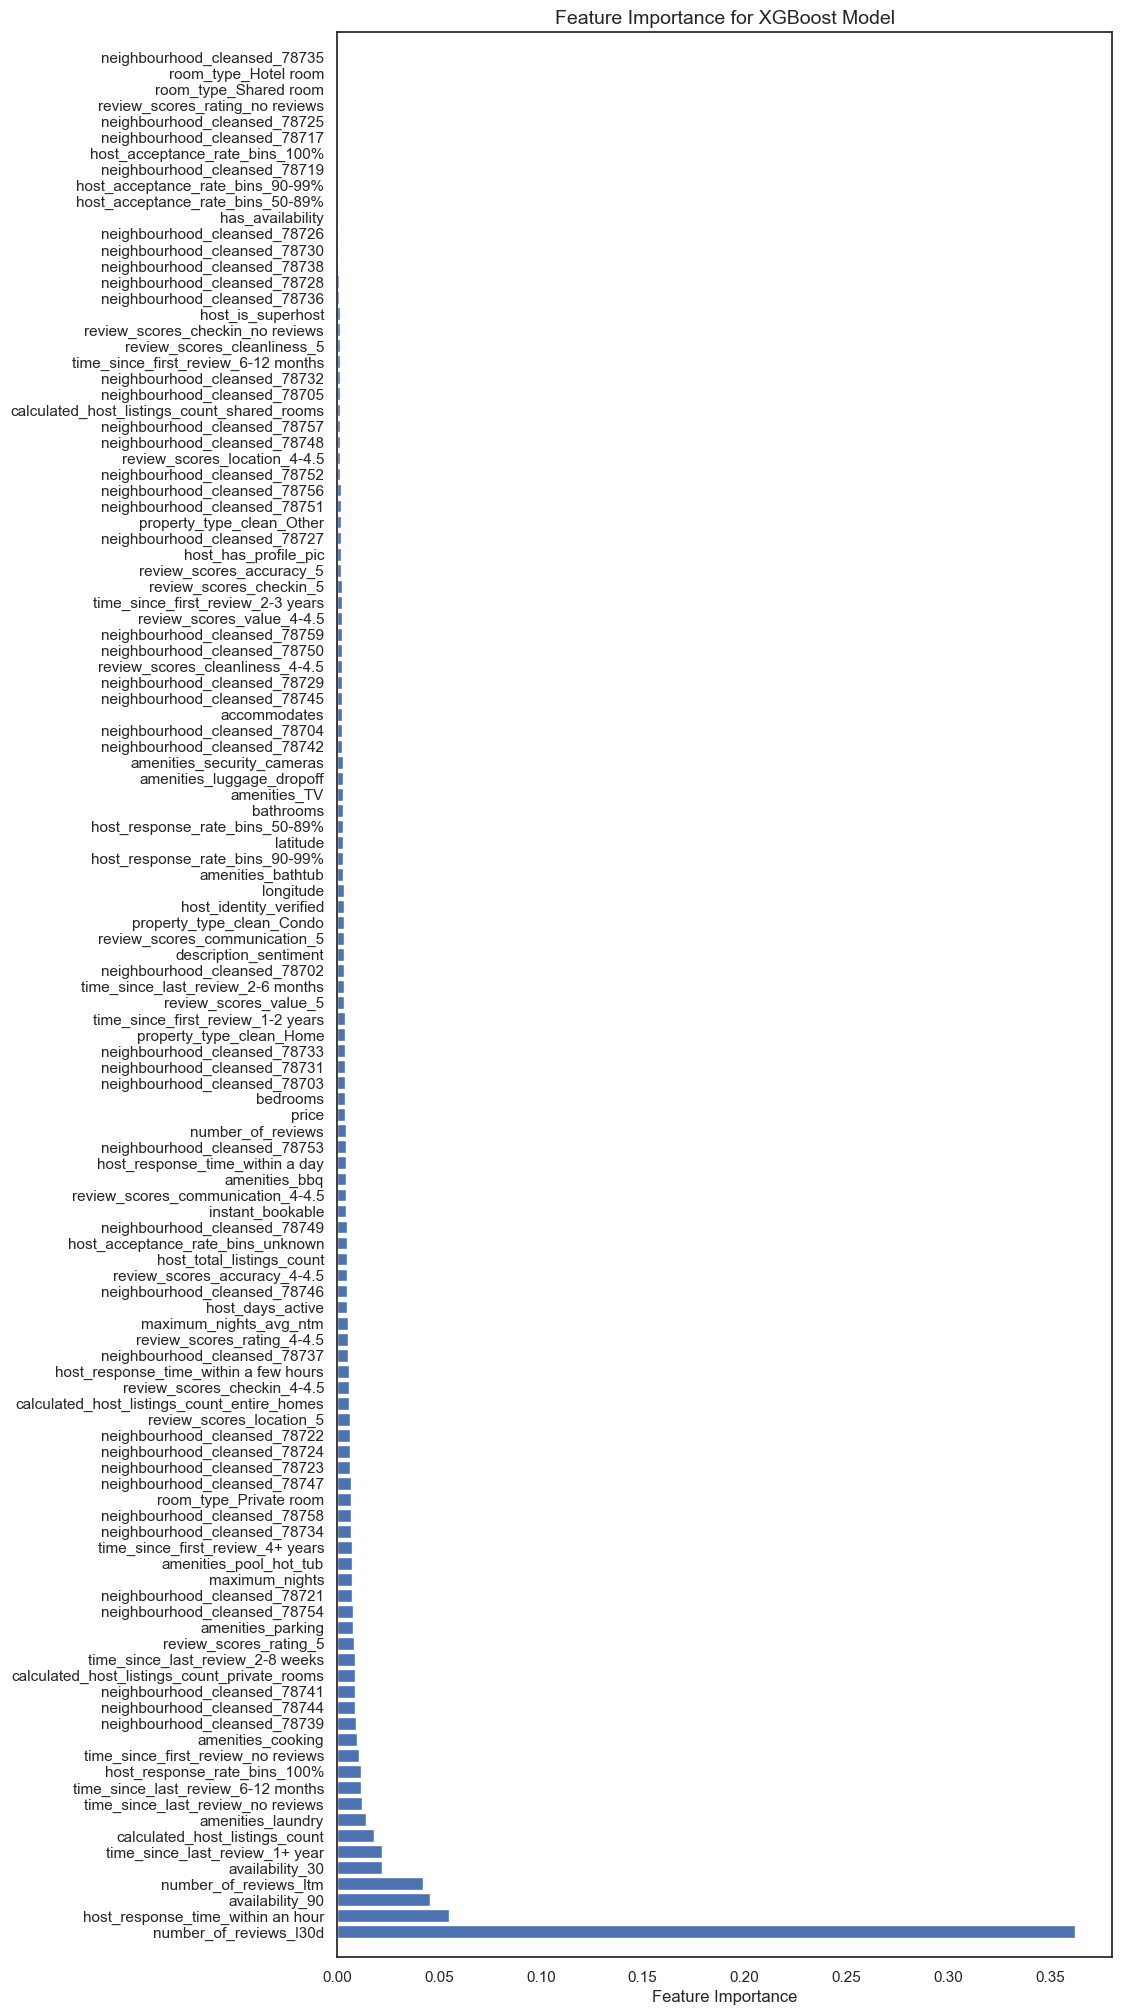

In [25]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)

# Plotting feature importances
plt.figure(figsize=(10,25))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature Importance for XGBoost Model", fontsize=14)
plt.xlabel("Feature Importance")
plt.margins(y=0.01)
plt.show()

## Classification Case

Try to predict the binary flag `nights_booked_flag`

In [93]:
classifier_metadata = []

In [101]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to execute model and addd metadata
def execute_classifier(model, model_metadata, X_train, X_test, Y_train, Y_test, id):
    model.fit(X_train,Y_train)

    Y_train_pred  = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # Get confusion matrix objects for training and testing data and display to user
    # conf = confusion_matrix(Y_train, Y_train_pred)
    # conf_test = confusion_matrix(Y_test, Y_test_pred)

    disp = ConfusionMatrixDisplay.from_estimator(model, X_train,Y_train)
    disp.ax_.set_title("Training Confusion Matrix: "+id)

    disp_test = ConfusionMatrixDisplay.from_estimator(model, X_test,Y_test)
    disp_test.ax_.set_title("Validation Confusion Matrix: "+id)

    # Acquire train/test sensetivity scores
    recall_train = recall_score(Y_train,Y_train_pred)
    recall_test = recall_score(Y_test,Y_test_pred)

    # Precision score for train/test data
    prec_train = precision_score(Y_train,Y_train_pred)
    prec_test = precision_score(Y_test,Y_test_pred)

    # F-1 score for train/test data
    f1_train = f1_score(Y_train, Y_train_pred)
    f1_test = f1_score(Y_test, Y_test_pred)

    # Acquire overall accuracy scores
    acc_train = accuracy_score(Y_train, model.predict(X_train))
    acc_test = accuracy_score(Y_test, model.predict(X_test))

    auc_train = roc_auc_score(Y_train, Y_train_pred)
    auc_test = roc_auc_score(Y_test, Y_test_pred)

    # Store results in model metadata obj
    meta_data = {"model": model, 
                "id": id,
                "acc_train": acc_train,
                "acc_test": acc_test,
                "recall_train": recall_train,
                "recall_test": recall_test,
                "prec_train": prec_train,
                "prec_test": prec_test,
                "f1_train": f1_train,
                "f1_test": f1_test,
                "auc_train": auc_train,
                "auc_test": auc_test}
    # Output the F1_train metric as an initial goodness score for each model
    model_metadata.append(meta_data)

    return meta_data

In [102]:
# Separating X and y
X = transformed_df.drop(['nights_booked_est','nights_booked_flag'], axis=1)
y = transformed_df.nights_booked_flag
X_unscaled = X.copy()

# Cols of interest
cols = ['latitude','longitude','accommodates','bathrooms',
                    'maximum_nights', 'maximum_nights_avg_ntm',
                    'number_of_reviews',
                    'number_of_reviews_ltm','number_of_reviews_l30d',
                    'calculated_host_listings_count','calculated_host_listings_count_entire_homes',
                    'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms',
                    'host_days_active','description_sentiment']

# Scaling, get zero mean, unit variance for all input features
num_features = X[cols].copy()
scaler = StandardScaler().fit(num_features.values)
num_features = scaler.transform(num_features.values)

X[cols] = num_features
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [110]:
(y==1).sum()


3050

In [111]:
(y==0).sum()


5784

In [103]:
# Splitting into train, validation, and test sets
# Distribution is 80/20, then 80/20 of the 80 percent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=57) 

### Logistic Regression

{'model': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
 'id': 'Logistic Regression Base',
 'acc_train': 0.8208031133911198,
 'acc_test': 0.8005657708628006,
 'recall_train': 0.7108684347373895,
 'recall_test': 0.6844106463878327,
 'prec_train': 0.7494517543859649,
 'prec_test': 0.7563025210084033,
 'f1_train': 0.7296503869762476,
 'f1_test': 0.7185628742514969,
 'auc_train': 0.7941741637493918,
 'auc_test': 0.776890007878601}

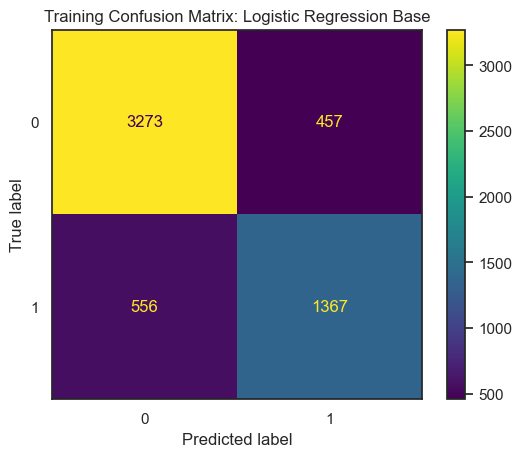

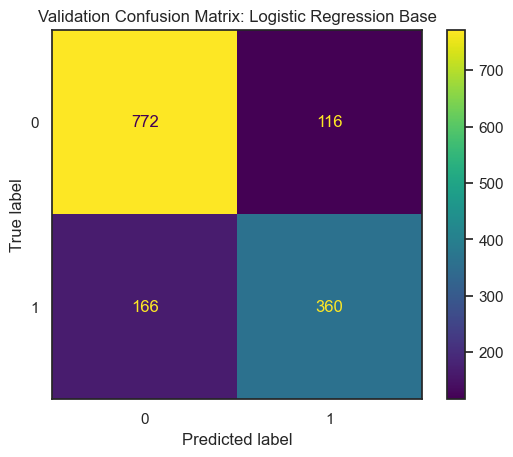

In [104]:
log_reg = linear_model.LogisticRegression(penalty ='l1',solver='liblinear',random_state=42)
execute_classifier(log_reg, classifier_metadata, X_train, X_val, y_train, y_val, 'Logistic Regression Base')

In [105]:
cols = np.array(X_val.columns)
coeff = log_reg.coef_[0]
mag = abs(coeff)

data = {"feature":cols, "coeff":coeff, "magnitude":mag}

df = pd.DataFrame(data)

df.sort_values('magnitude', ascending=False).head(20)


,feature,coeff,magnitude
81,review_scores_rating_no reviews,3.129339,3.129339
114,time_since_last_review_no reviews,-2.028666,2.028666
11,has_availability,1.283008,1.283008
113,time_since_last_review_6-12 months,-1.224875,1.224875
77,room_type_Private room,-1.164806,1.164806
41,neighbourhood_cleansed_78722,1.062323,1.062323
78,room_type_Shared room,-0.921459,0.921459
82,review_scores_accuracy_4-4.5,-0.843764,0.843764
110,time_since_last_review_1+ year,-0.783027,0.783027
13,number_of_reviews_ltm,0.773880,0.773880


### Decision Tree

In [106]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

params = [3,4,8,16,32]

for num in params:
    mod = DecisionTreeClassifier(max_depth=num, random_state=42)
    scores = cross_val_score(mod,  X_train, y_train, cv=5)
    print(f"Parameter: {num}, avg: {scores.mean()}, std: {scores.std()}")

Parameter: 3, avg: 0.7951551997996917, std: 0.00632359713838821
Parameter: 4, avg: 0.7944491130881122, std: 0.00949018327838368
Parameter: 8, avg: 0.7801200284813345, std: 0.012667624054359288
Parameter: 16, avg: 0.7573013153055875, std: 0.011891747727930129
Parameter: 32, avg: 0.7571210378473119, std: 0.00722983607097617


{'model': DecisionTreeClassifier(max_depth=4, random_state=42),
 'id': 'Decision Tree Base',
 'acc_train': 0.8027595966743322,
 'acc_test': 0.7878359264497878,
 'recall_train': 0.7618304732189287,
 'recall_test': 0.7547528517110266,
 'prec_train': 0.6903864278982093,
 'prec_test': 0.698943661971831,
 'f1_train': 0.7243510506798516,
 'f1_test': 0.7257769652650824,
 'auc_train': 0.7928455315156306,
 'auc_test': 0.7810926420717295}

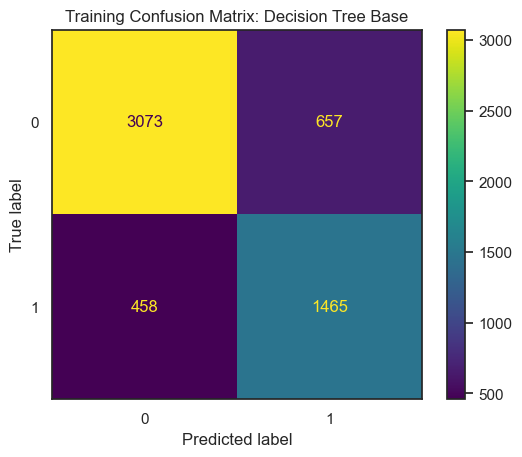

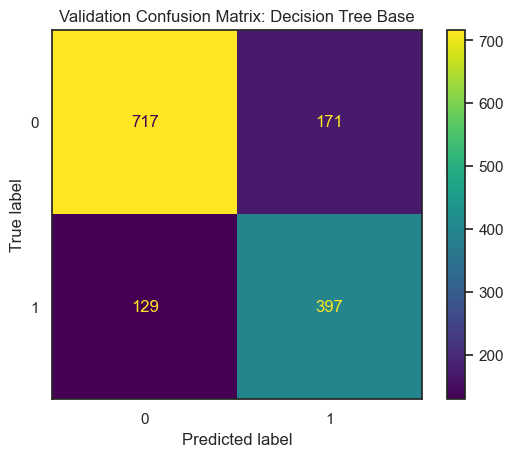

In [107]:
dec_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
execute_classifier(dec_tree, classifier_metadata, X_train, X_val, y_train, y_val, 'Decision Tree Base')

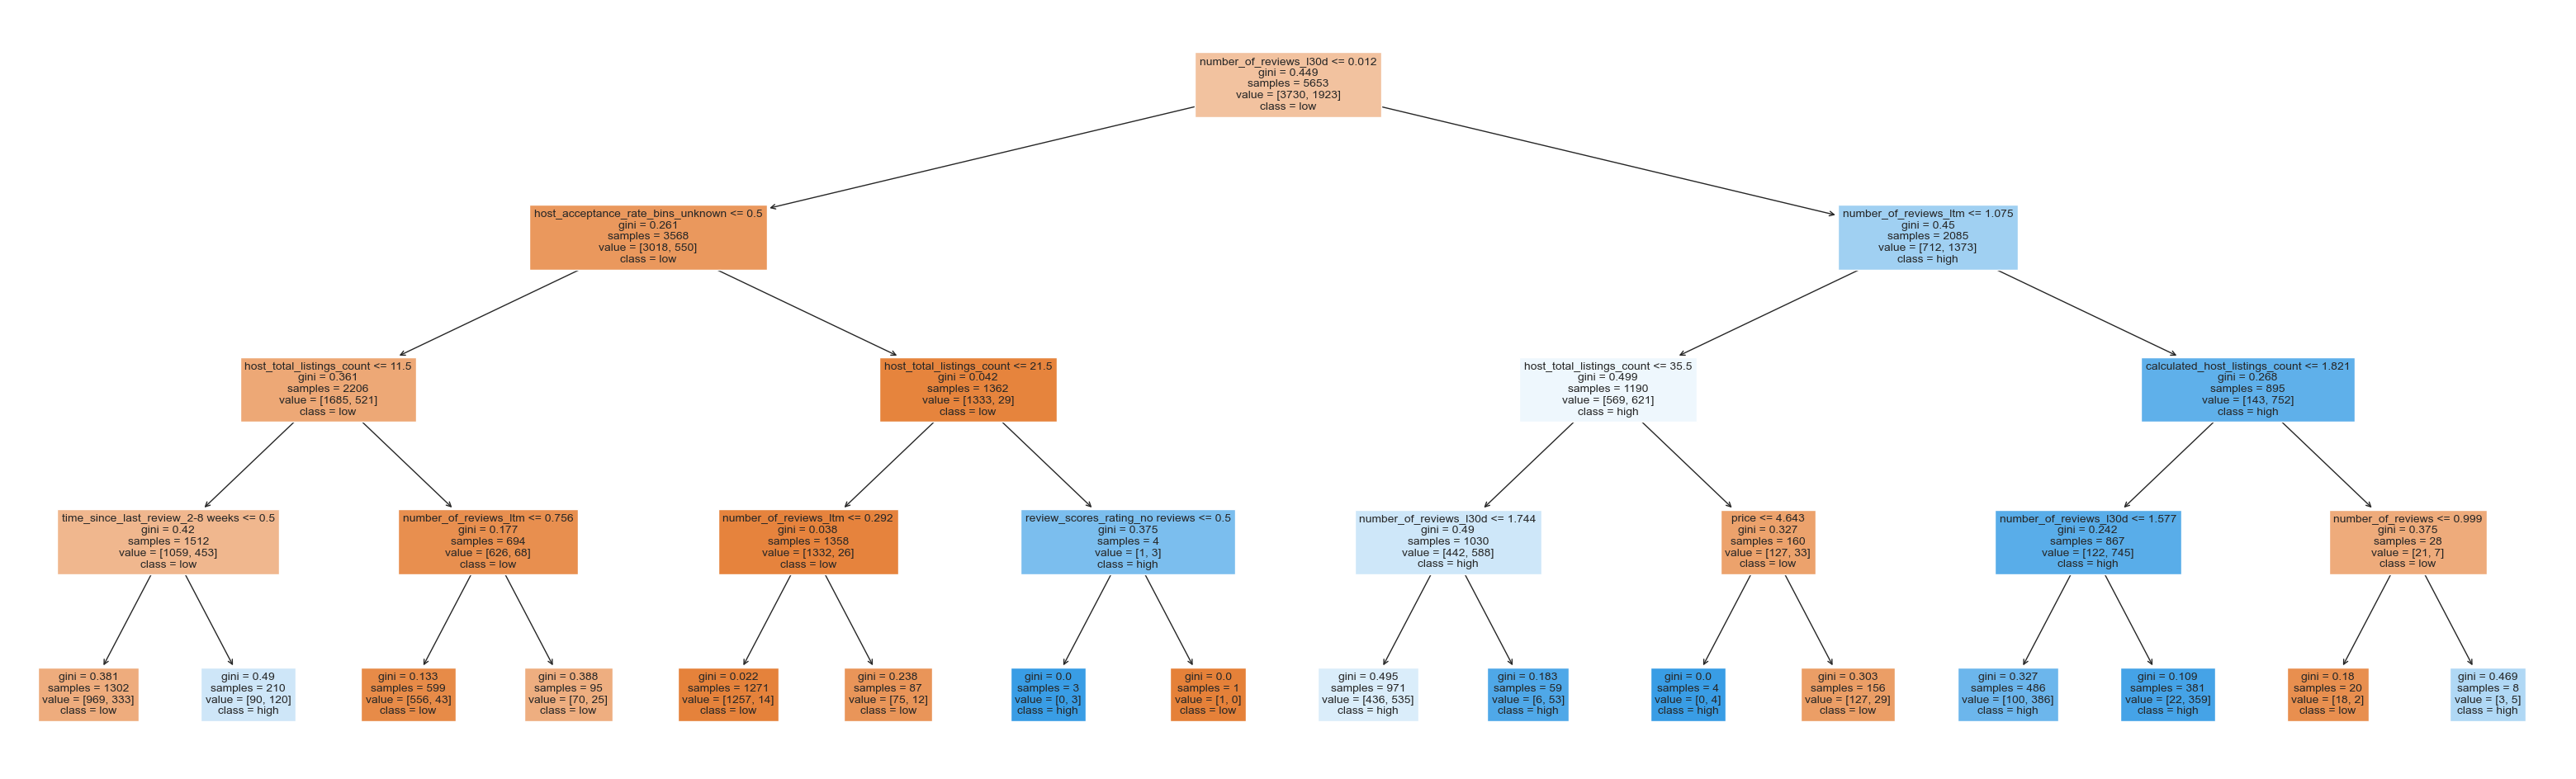

In [108]:
plt.figure(figsize=(40,12))  
plot_tree(dec_tree, fontsize=10, feature_names=X_train.columns, class_names=['low','high'], filled=True)
plt.show()